In [17]:
%matplotlib inline

import os
import copy
import random
import colorsys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageChops
from scipy import misc
from scipy import ndimage

matplotlib.rcParams['figure.figsize'] = (20, 20)

# Read in sample images

In [20]:
image = misc.imread('data/image/test1.png', mode="RGBA")
skin = misc.imread('data/skin/test1.png', mode='L')
shirt = misc.imread('data/shirt/test1.png', mode='L')
pants = misc.imread('data/pants/test1.png', mode='L')
ao = misc.imread('data/AO/test1.png')
bkgd = misc.imread('data/background/test1.jpg', mode='RGBA')
bkgd2 = misc.imread('data/background/test2.jpg', mode='RGBA')

# Define emoji modifier skin tones

In [3]:
f1 = (254, 215, 196)
f2 = (223, 175, 145)
f3 = (225, 164, 111)
f4 = (148, 70, 32)
f5 = (72, 33, 6)

emoji_skin = [f1, f2, f3, f4, f5]

In [8]:
def isolate_item(rendered_image, item_mask):
    """use given mask as an alpha for the rendered image
    rendered_image: RGBA ndimage
    item_mask: L ndimage
    masked_image: PIL RGBA image
    """
    masked_image = copy.copy(rendered_image)
    masked_image[:, :, 3] = item_mask
    masked_image = Image.fromarray(masked_image)
    
    return masked_image


def combine_with_color(original_image, item, color_block):
    rendered_item = isolate_item(original_image, item)
    colored_item = ImageChops.multiply(rendered_item, color_block)
    
    return colored_item


def combine_display(image, item, color_block):
    """combine rendered image, isolated to item with a color block and display"""
    
    rendered_item = isolate_item(image, item)
    colored_item = combine_with_color(image, item, color_block)
    
    fig = plt.figure()
    fig.add_subplot(1, 3, 1)
    plt.imshow(rendered_item)
    fig.add_subplot(1, 3, 2)
    plt.imshow(color_block)
    fig.add_subplot(1, 3, 3)
    plt.imshow(colored_item)
    
    
def skin_block(original_image, emoji_skin):
    """Return random block of emoji skin tone size of image"""
    return Image.new('RGBA', original_image.shape[:2], color=random.choice(emoji_skin))


def color_block(original_image):
    """Return random block of color """
    hsv = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    rgb = colorsys.hsv_to_rgb(hsv[0], hsv[1], hsv[2])
    r = int(rgb[0] * 255)
    g = int(rgb[1] * 255)
    b = int(rgb[2] * 255)
    return Image.new('RGBA', original_image.shape[:2], color=(r, g, b))


def resize_image(image, new_size):
    new_img = image.resize(new_size, resample=Image.BILINEAR)

    return new_img


def rotate_image(image):
    """Randomly rotate input image"""
    rot_angle = random.uniform(0, 360)
    rot_image = image.rotate(rot_angle, resample=Image.BILINEAR)

    return rot_image


def new_person_size(person_size, bg_size):
    """Generate new (random) size for the person image that will fit within the bg"""
    person_w = person_size[0]
    person_h = person_size[1]
    assert person_h == person_w

    bg_w = bg_size[0]
    bg_h = bg_size[1]
    max_side = max(bg_w, bg_h) * 2
    min_size = min(bg_w, bg_h) * 0.10

    new_w = int(random.uniform(min_size, max_side))
    new_size = (new_w, new_w)

    return new_size


def new_ul_location(new_person_size, bg_size):
    """Generate new upper left location for person within bg with >50% image visible"""
    min_left = 0 - new_person_size[0] * 0.25
    max_left = bg_size[0] - new_person_size[0] * 0.75
    min_top = 0 - new_person_size[1] * 0.25
    max_top = bg_size[1] - new_person_size[1] * 0.75

    new_x = int(random.uniform(min_left, max_left))
    new_y = int(random.uniform(min_top, max_top))

    return (new_x, new_y)


def generate_overlay(person, bg_image):
    """Generate overlay image with resized person on blank alpha"""
    person_size = person.size
    bg_size = Image.fromarray(bg_image).size

    new_size = new_person_size(person_size, bg_size)
    new_xy = new_ul_location(new_size, bg_size)

    resized_person = resize_image(person, new_size)
    resized_person = rotate_image(resized_person)

    overlay = Image.new('RGBA', bg_size)
    overlay.paste(resized_person, box=new_xy)

    return overlay

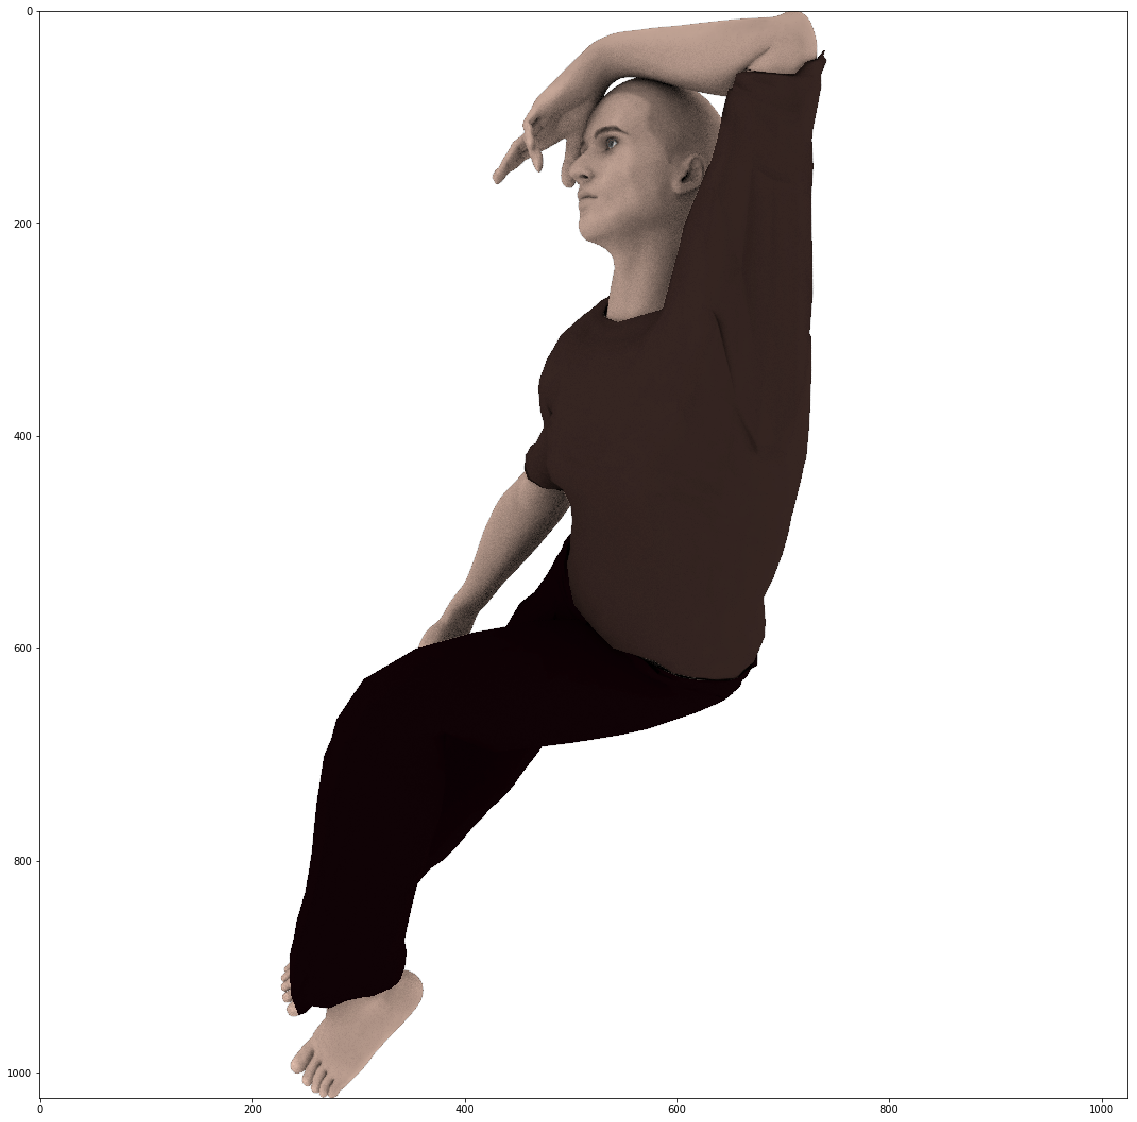

In [9]:
new_skin = combine_with_color(image, skin, skin_block(image, emoji_skin))
new_shirt = combine_with_color(image, shirt, color_block(image))
new_pants = combine_with_color(image, pants, color_block(image))

clothes = Image.alpha_composite(new_shirt, new_pants)
comp = Image.alpha_composite(new_skin, clothes)
comp = Image.alpha_composite(Image.fromarray(image), comp)
comp = ImageChops.multiply(comp, Image.fromarray(ao))

plt.imshow(comp)
plt.show()

# Try color/histogram matching

In [10]:
def as_ndarray(image):
    """convert to ndarray if needed"""
    if type(image) == Image.Image:
        image = np.asarray(image)

    assert type(image) == np.ndarray, '{} is wrong type'.format(image)

    return image


def make_image_uint8(image):
    """make sure image is 255, uint8 formatted"""
    if image.dtype != 'uint8':
        if np.max(image) <= 1:
            image = image * 255
        image = image.astype('uint8')

    return image


def cdf_norm(array, bins):
    """find the normalized cumulative distribution of array"""
    cdf = array.cumsum()
    cdf = (bins * cdf / cdf[-1]).astype(np.uint8)
    
    return cdf


def match_background(foreground_img, background_img):
    """use histogram matching to match the foreground more closely to background

    :param foreground_img: ndimage 4 channel array
    :param background_img: ndimage
    :return:
    """
    foreground_img = as_ndarray(foreground_img)
    background_img = as_ndarray(background_img)

    foreground = make_image_uint8(foreground_img)
    foreground_rgb = foreground[:, :, :3]
    foreground_a = foreground[:, :, 3]

    background = make_image_uint8(background_img)

    matched = foreground.copy()
    
    n_bins = 255

    for d in range(foreground_rgb.shape[2]):
        f_hist, bins = np.histogram(foreground_rgb[:, :, d].flatten(), bins=n_bins, density=True,
                                    weights=foreground_a.flatten())
        b_hist, bins = np.histogram(background[:, :, d], bins=n_bins, density=True)

        cdf_f = cdf_norm(f_hist, n_bins)
        cdf_b = cdf_norm(b_hist, n_bins)
        
#         np.interp(imsrc[:,:,d].flatten(),bins[:-1],cdfsrc)

        im2 = np.interp(foreground_rgb[:, :, d].flatten(), bins[:-1], cdf_f)
        im3 = np.interp(im2, cdf_b, bins[:-1])

        matched[:, :, d] = im3.reshape((foreground.shape[0], foreground.shape[1]))

    return matched

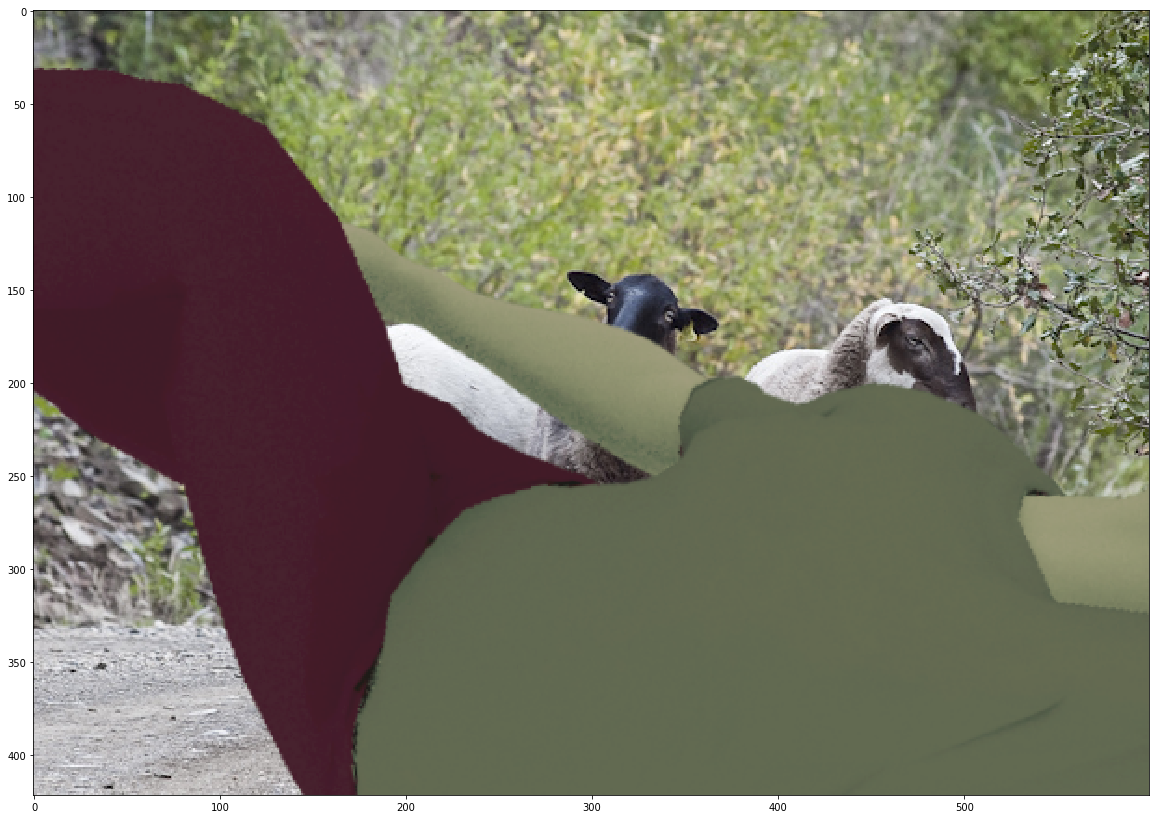

In [11]:
test = match_background(comp, bkgd)

over = generate_overlay(Image.fromarray(test), bkgd)
train_image = Image.alpha_composite(Image.fromarray(bkgd), over)

plt.imshow(train_image)
plt.show()

In [12]:
from skimage import color

def match_background_brightness(foreground_img, background_img):
    """use histogram matching to match the foreground more closely to background

    :param foreground_img: ndimage 4 channel array
    :param background_img: ndimage
    :return:
    """
    foreground_img = as_ndarray(foreground_img)
    background_img = as_ndarray(background_img)

    foreground = make_image_uint8(foreground_img)
    foreground_rgb = foreground[:, :, :3]
    foreground_lab = color.rgb2lab(foreground_rgb)
    foreground_a = foreground[:, :, 3]

    background = make_image_uint8(background_img)
    background_lab = color.rgb2lab(background[:, :, :3])

    matched = foreground.copy()
    matched_lab = foreground_lab.copy()
    
    n_bins = 255

    for d in range(foreground_lab.shape[2]):
        f_hist, bins = np.histogram(foreground_lab[:, :, d].flatten(), bins=n_bins, density=True,
                                    weights=foreground_a.flatten())
        b_hist, bins = np.histogram(background_lab[:, :, d], bins=n_bins, density=True)

        cdf_f = cdf_norm(f_hist, n_bins)
        cdf_b = cdf_norm(b_hist, n_bins)
        
#         np.interp(imsrc[:,:,d].flatten(),bins[:-1],cdfsrc)

        im2 = np.interp(foreground_lab[:, :, d].flatten(), bins[:-1], cdf_f)
        im3 = np.interp(im2, cdf_b, bins[:-1])

        matched_lab[:, :, d] = im3.reshape((foreground.shape[0], foreground.shape[1]))
        
    foreground_lab[:, :, :3] = matched_lab[:, :, :3]
    foreground_corrected = color.lab2rgb(matched_lab)
    foreground_corrected = foreground_corrected * 255
    matched[:, :, :3] = foreground_corrected[:, :, :3]

    return matched

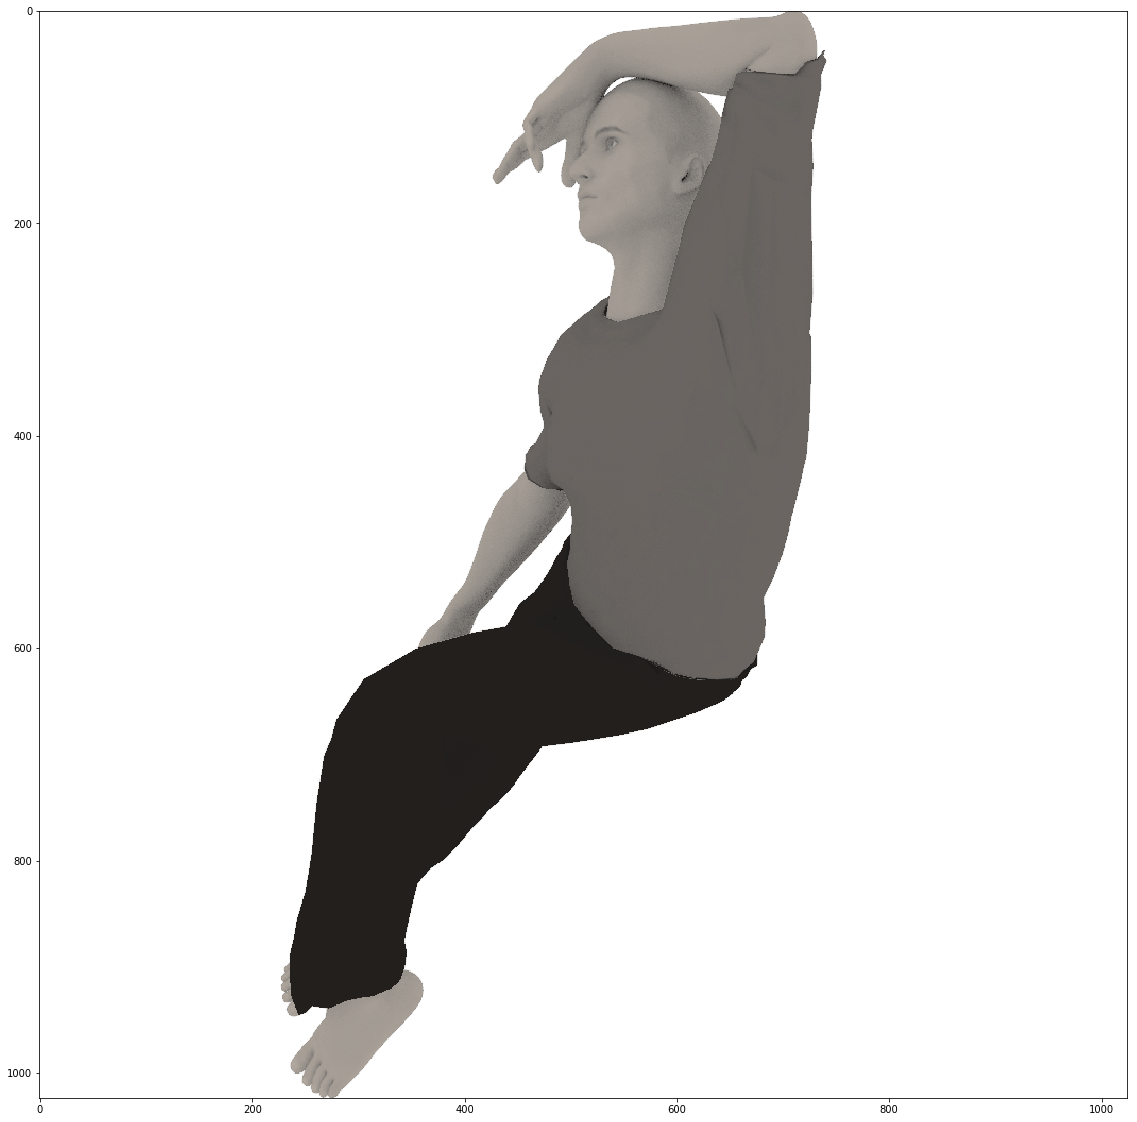

In [13]:
test2 = match_background_brightness(comp, bkgd)
plt.imshow(test2)
plt.show()

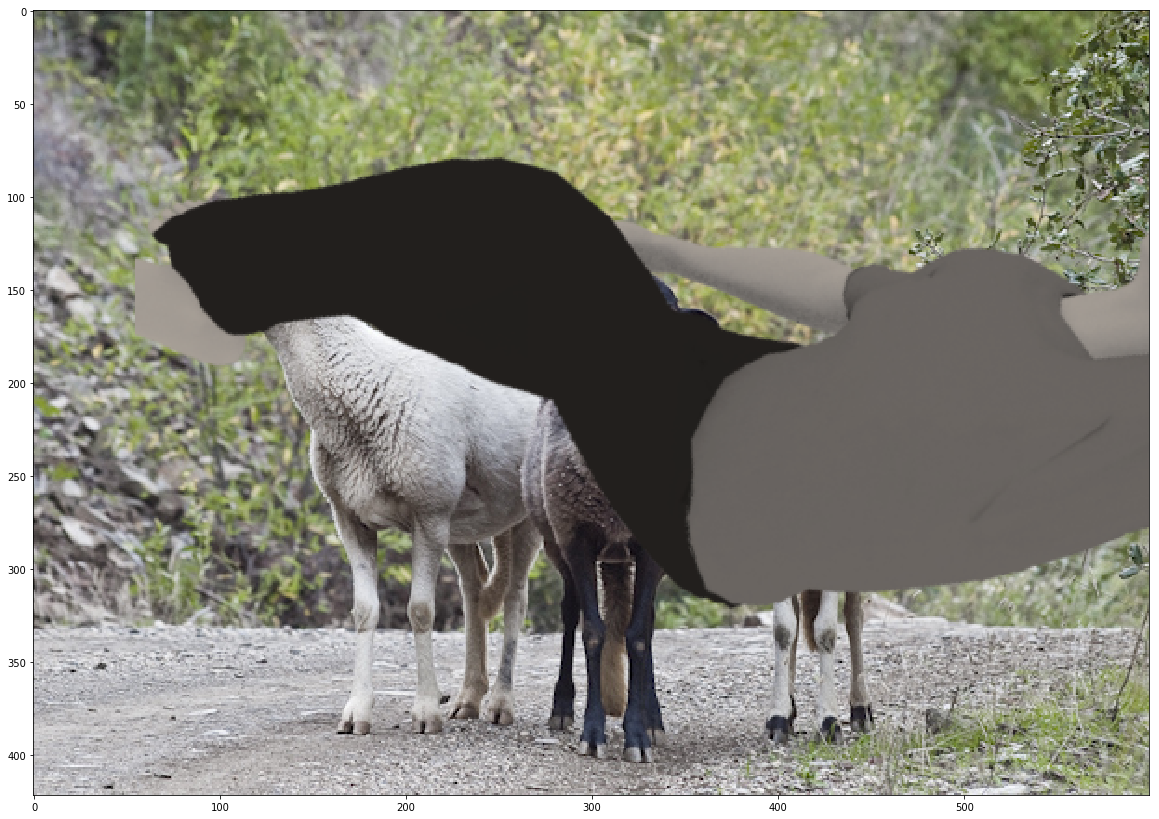

In [14]:
over = generate_overlay(Image.fromarray(test2), bkgd)
train_image = Image.alpha_composite(Image.fromarray(bkgd), over)

plt.imshow(train_image)
plt.show()

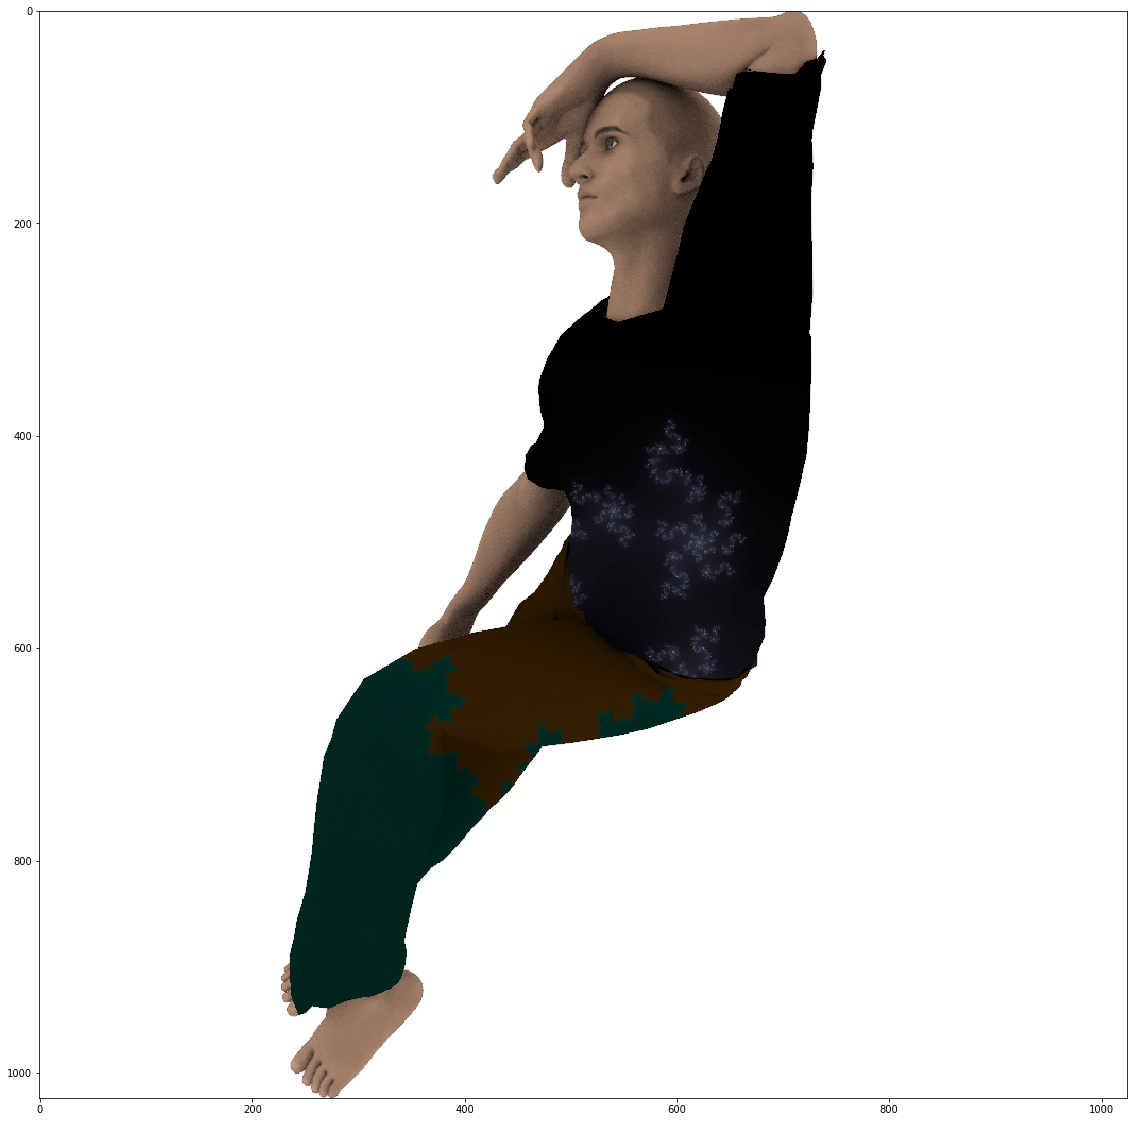

In [35]:
pattern_list = []
path = './data/costumes'
for file in os.listdir(path):
    if file.endswith('.png'):
        pattern_list.append(os.path.join(path, file))

new_skin = combine_with_color(image, skin, skin_block(image, emoji_skin))

costume1 = Image.fromarray(misc.imread(random.choice(pattern_list), mode='RGBA'))
new_shirt = combine_with_color(image, shirt, costume1)

costume2 = Image.fromarray(misc.imread(random.choice(pattern_list), mode='RGBA'))
new_pants = combine_with_color(image, pants, costume2)

test_combine = Image.alpha_composite(new_shirt, new_pants)
test_combine = Image.alpha_composite(new_skin, test_combine)
base = Image.fromarray(image)
test_combine = Image.alpha_composite(base, test_combine)
test_combine = ImageChops.multiply(test_combine, Image.fromarray(ao))

plt.imshow(test_combine)
plt.show()